In [80]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Common

In [81]:
import torch
from transformers import T5Tokenizer, T5ForConditionalGeneration
import pandas as pd
from tqdm.auto import tqdm

from transformers import pipeline

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [82]:
img_path = '/content/drive/My Drive/Colab Notebooks/8_Text_Paraphrasing/plots/'

# Corpus

In [83]:
dataset = 'manual' # mrpc, manual
model_name = 't5-small' #t5-small, t5-base

folder_input_cor_path = '/content/drive/My Drive/Colab Notebooks/8_Text_Paraphrasing/data/'
folder_pretrained_path = f'/content/drive/My Drive/Colab Notebooks/8_Text_Paraphrasing/pretrained/{dataset}-{model_name}-cc'
csv_file_path = f'{dataset}-triplet-corpus-extended.csv'
folder_pretrained_path

'/content/drive/My Drive/Colab Notebooks/8_Text_Paraphrasing/pretrained/manual-t5-small-cc'

In [84]:
# Load the dataset
df_cor = pd.read_csv(folder_input_cor_path + csv_file_path)
# Split the dataset into training and validation sets
df_cor = df_cor[['original', 'positive', 'negative',
               'positive_sentiment_label', 'positive_sentiment_score',
               'negative_sentiment_label', 'negative_sentiment_score',
               'positive_bert', 'negative_bert',
               'positive_cosine_similarity',
               'negative_cosine_similarity', 'split']]
df_cor.shape[0]

212

# Influence

In [85]:
folder_inf_input_path = '/content/drive/My Drive/Colab Notebooks/4_Influencing_Signal/data-hrv-kaggle/'

In [86]:
df_inf = pd.read_csv(folder_inf_input_path + '/test.csv')
# Mapping for condition to influence
stress_name_map = {
    'interruption': 'NEG',
    'time pressure': 'NEG',
    'no stress': 'POS',
}

# Assign stress_name based on condition
df_inf['influence'] = df_inf['condition'].map(stress_name_map)

#Generate paraprases

In [87]:
tokenizer = T5Tokenizer.from_pretrained(folder_pretrained_path)
model = T5ForConditionalGeneration.from_pretrained(folder_pretrained_path)
# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


T5ForConditionalGeneration(
  (shared): Embedding(32128, 512)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 512)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=512, out_features=512, bias=False)
              (k): Linear(in_features=512, out_features=512, bias=False)
              (v): Linear(in_features=512, out_features=512, bias=False)
              (o): Linear(in_features=512, out_features=512, bias=False)
              (relative_attention_bias): Embedding(32, 8)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseActDense(
              (wi): Linear(in_features=512, out_features=2048, bias=False)
              (wo): Linear(in_features=2048, out_features=512, bias=False)
              (dropout): Drop

In [88]:
df = df_cor.join(df_inf['influence'])

model.eval()
for index, row in tqdm(df.iterrows(), total=df.shape[0]):
    input_text = f"paraphrase: [{row['influence']}] {row['original']}"
    input_token = tokenizer.encode(input_text, return_tensors="pt").to(device)
    generated_ids = model.generate(input_token, max_length=50, num_beams=5, early_stopping=True)
    paraphrase = tokenizer.decode(generated_ids[0], skip_special_tokens=True)
    df.at[index, 'influence_paraphrase'] = paraphrase

  0%|          | 0/212 [00:00<?, ?it/s]

#Extract paraphrases sentiment

In [89]:
tqdm.pandas()

# Load the sentiment analysis pipeline
model = pipeline('sentiment-analysis', model="finiteautomata/bertweet-base-sentiment-analysis")

# Function to get sentiment label and score
def get_sentiment(sentence):
    result = model(sentence)[0]
    return result['label'], result['score']

# Apply the function to each sentence column and create new columns for label and score
for column in ['influence_paraphrase']:
    df[[column + '_sentiment_label', column + '_sentiment_score']] = df[column].progress_apply(
        lambda x: pd.Series(get_sentiment(x))
    )

# df.head()

emoji is not installed, thus not converting emoticons or emojis into text. Install emoji: pip3 install emoji==0.6.0


  0%|          | 0/212 [00:00<?, ?it/s]

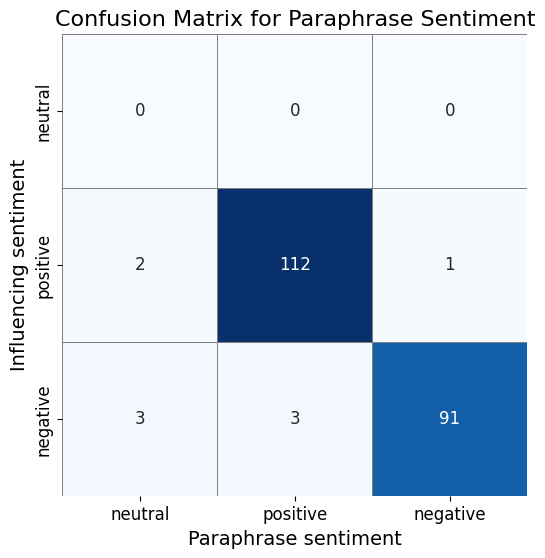

In [90]:
# Prepare the data
true_labels = df['influence']
predicted_labels = df['influence_paraphrase_sentiment_label']

# Create the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels, labels=["NEU", "POS", "NEG"])

# Plot the confusion matrix
plt.figure(figsize=(6, 6))  # Larger figure size
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=["neutral", "positive", "negative"], yticklabels=["neutral", "positive", "negative"], linewidths=0.5, linecolor='gray', cbar=False, annot_kws={"size": 12})
plt.title('Confusion Matrix for Paraphrase Sentiment', fontsize=16)
plt.xlabel('Paraphrase sentiment', fontsize=14)
plt.ylabel('Influencing sentiment', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.savefig(img_path + f'{dataset}-confusion_matrix-influenced-paraphrase-sentiment.png', dpi=300, bbox_inches='tight')
plt.show()

In [91]:
import numpy as np

no_stress_count = np.count_nonzero(df['influence'] == 'POS')
stress_count = np.count_nonzero(df['influence'] == 'NEG')

# Ratio calculation
no_stress_ratio = no_stress_count / df.shape[0]
stress_ratio = stress_count / df.shape[0]

print(round(no_stress_ratio*100,2), round(stress_ratio*100,2))
print(no_stress_count, stress_count)

54.25 45.75
115 97


In [92]:
no_stress_count = np.count_nonzero(df['influence_paraphrase_sentiment_label'] == 'POS')
stress_count = np.count_nonzero(df['influence_paraphrase_sentiment_label'] == 'NEG')
other_count = np.count_nonzero(df['influence_paraphrase_sentiment_label'] == 'NEU')

# Ratio calculation
no_stress_ratio = no_stress_count / df.shape[0]
stress_ratio = stress_count / df.shape[0]
other_ratio = other_count / df.shape[0]


print(round(no_stress_ratio*100,2), round(stress_ratio*100,2), round(other_ratio*100,2))
print(no_stress_count, stress_count, other_count)

54.25 43.4 2.36
115 92 5


In [93]:
category_names = {'POS': 'Positive', 'NEG': 'Negative', 'NEU': 'Neutral'}
categories_updated = [category_names[cat] for cat in categories]

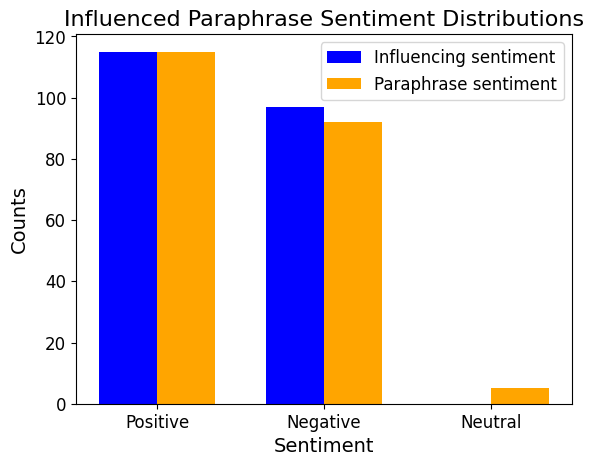

In [94]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Count occurrences of each category in both attributes
influence_counts = df['influence'].value_counts().reindex(['POS', 'NEG', 'NEU'], fill_value=0)
influence_paraphrase_counts = df['influence_paraphrase_sentiment_label'].value_counts().reindex(['POS', 'NEG', 'NEU'], fill_value=0)

# Prepare data for plotting
categories = influence_counts.index
pos = np.arange(len(categories))
bar_width = 0.35

# Creating the grouped bar chart
# plt.figure(figsize=(8, 6))
fig, ax = plt.subplots()
bars1 = ax.bar(pos - bar_width/2, influence_counts, bar_width, label='Influencing sentiment', color='blue')
bars2 = ax.bar(pos + bar_width/2, influence_paraphrase_counts, bar_width, label='Paraphrase sentiment', color='orange')

ax.set_xlabel('Sentiment', fontsize=14)
ax.set_ylabel('Counts', fontsize=14)
ax.set_title('Influenced Paraphrase Sentiment Distributions', fontsize=16)
ax.set_xticks(pos)
ax.set_xticklabels(categories_updated)
ax.legend(fontsize=12)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)


# plt.tight_layout()

plt.savefig(img_path + f'{dataset}-distribution-influenced-paraphrase-sentiment.png', dpi=300, bbox_inches='tight')
plt.show()


In [95]:
# # Combining both attributes and splits into a single stacked bar chart
# # We will create bars for each combination of attribute and split category within each sentiment category

# # Preparing data
# categories = ['POS', 'NEG', 'NEU']
# splits = ['train', 'test']
# attributes = ['influence', 'influence_paraphrase_sentiment_label']

# # Count occurrences for each combination of attribute, category, and split
# counts = {(attr, cat, split): df[(df[attr] == cat) & (df['split'] == split)].shape[0]
#           for attr in attributes for cat in categories for split in splits}

# # Plotting
# fig, ax = plt.subplots(figsize=(12, 8))

# # Setup for stacked bars
# bar_width = 0.35
# pos = np.arange(len(categories))  # Base positions for each category
# offset = bar_width / len(splits)  # Calculate offset to position bars side by side

# # Generate bars
# for i, attr in enumerate(attributes):
#     for j, split in enumerate(splits):
#         heights = [counts[(attr, cat, split)] for cat in categories]
#         ax.bar(pos + (i * offset) - (bar_width / 2), heights, bar_width / len(attributes),
#                label=f'{attr} ({split})', bottom=0 if j == 0 else [counts[(attr, cat, splits[j-1])] for cat in categories])

# ax.set_xlabel('Category')
# ax.set_ylabel('Counts')
# ax.set_title('Combined Distribution of Influence and Influence Paraphrase Sentiment Label by Train/Test Split')
# ax.set_xticks(pos)
# ax.set_xticklabels(categories)
# ax.legend()

# plt.tight_layout()
# plt.show()


In [96]:
!pip install -q bert-score

In [97]:
!pip install -q sentence_transformers

In [98]:
from transformers import BertTokenizer, BertForMaskedLM, BertModel
from bert_score import BERTScorer

scorer = BERTScorer(model_type='bert-base-uncased', device=None, lang='en')


def compute_bertscore(original, paraphrase):
    # Since BERTScore expects lists of sentences, wrap inputs in lists
    P, R, F1 = scorer.score([paraphrase], [original], verbose=False)

    # Return the F1 score
    return F1.item()

# Add new columns for scores of positive and negative paraphrases
for index, row in tqdm(df.iterrows(), total=df.shape[0]):
    # Assigning scores to the DataFrame
    df.at[index, 'influenced_paraphrase_bert'] = compute_bertscore(row['original'], row['influence_paraphrase'])

# df.head()

  0%|          | 0/212 [00:00<?, ?it/s]

In [99]:
from sentence_transformers import SentenceTransformer, util

# Load the model
model = SentenceTransformer('all-mpnet-base-v2')

def compute_cosine_similarity(original, paraphrase, threshold=0.75):
    # Compute embeddings
    embeddings_original = model.encode(original, convert_to_tensor=True)
    embeddings_paraphrase = model.encode(paraphrase, convert_to_tensor=True)

    # Compute cosine similarity
    cosine_scores = util.pytorch_cos_sim(embeddings_original, embeddings_paraphrase)

    return cosine_scores.item() # >= threshold

for index, row in tqdm(df.iterrows(), total=df.shape[0]):
    df.at[index, 'influenced_paraphrase_cosine_similarity'] = compute_cosine_similarity(row['original'], row['influence_paraphrase'])

df.head()

  0%|          | 0/212 [00:00<?, ?it/s]

,original,positive,negative,positive_sentiment_label,positive_sentiment_score,negative_sentiment_label,negative_sentiment_score,positive_bert,negative_bert,positive_cosine_similarity,negative_cosine_similarity,split,influence,influence_paraphrase,influence_paraphrase_sentiment_label,influence_paraphrase_sentiment_score,influenced_paraphrase_bert,influenced_paraphrase_cosine_similarity
0,The film showcases impressive visuals.,The movie's visuals were breathtakingly beauti...,"Despite stunning visuals, the movie lacked a s...",POS,0.990782,NEG,0.913526,0.667225,0.726314,0.798778,0.529715,train,POS,The movie's visuals were breathtakingly beauti...,POS,0.990782,0.667225,0.798778
1,The class size is large.,The large class size creates a dynamic and div...,The class's large size can impede personal att...,POS,0.940340,NEG,0.817363,0.671621,0.622664,0.723778,0.775589,train,NEG,The class's large size can impede personal att...,NEG,0.817363,0.622664,0.775589
2,The garden needs maintenance.,Maintaining the garden presents a wonderful op...,The garden's constant need for maintenance is ...,POS,0.992188,NEG,0.764199,0.645871,0.646032,0.768960,0.798920,train,POS,Maintaining the garden presents a wonderful op...,POS,0.992188,0.645871,0.768960
3,The climate is changing.,The changing climate presents opportunities fo...,The effects of climate change are causing cata...,POS,0.968780,NEG,0.960525,0.629758,0.587202,0.588102,0.724617,train,POS,The changing climate presents opportunities fo...,POS,0.968780,0.629758,0.588102
4,The restaurant has everyday ambiance.,The restaurant has a pleasant and inviting amb...,The restaurant's ambiance is just passable and...,POS,0.990005,NEG,0.965430,0.827058,0.745404,0.789276,0.386510,train,NEG,The restaurant's ambiance is weird and frighte...,NEG,0.966329,0.708594,0.407302


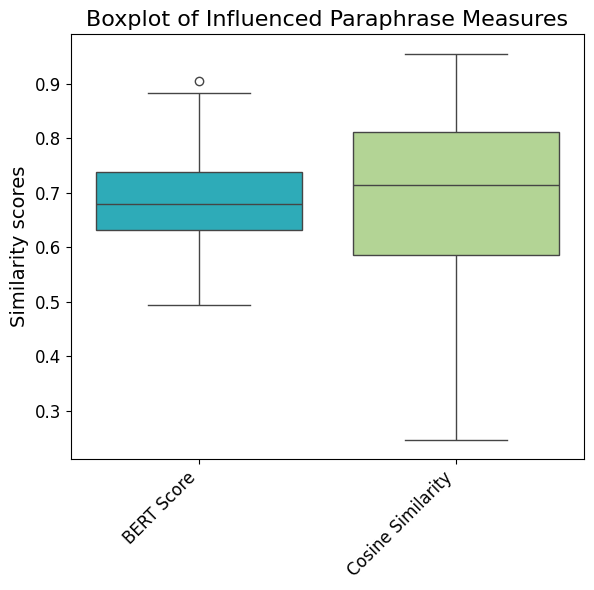

In [100]:
influenced_column_labels = {
    'influenced_paraphrase_bert': 'BERT Score',
    'influenced_paraphrase_cosine_similarity': 'Cosine Similarity'
}

# Select the data for positive and negative measures
influenced_data = df[influenced_column_labels.keys()]

# Define an expanded color palette suitable for color-blind readers
color_palette = [
    '#17becf',  # Cyan
    '#b2df8a',  # Light Green
]

# Plot for positive measures
plt.figure(figsize=(6, 6))
sns.boxplot(data=influenced_data, palette=color_palette)
plt.xticks(range(len(influenced_column_labels)), list(influenced_column_labels.values()), rotation=45, ha="right", fontsize=12)
plt.title('Boxplot of Influenced Paraphrase Measures', fontsize=16)
plt.ylabel('Similarity scores', fontsize=14)
plt.tight_layout()
plt.yticks(fontsize=12)

plt.savefig(img_path + f'{dataset}-boxplot-influenced-paraphrase-similarity.png', dpi=300, bbox_inches='tight')
plt.show()

In [101]:
df[['original', 'influence_paraphrase']].head(20)

,original,influence_paraphrase
0,The film showcases impressive visuals.,The movie's visuals were breathtakingly beauti...
1,The class size is large.,The class's large size can impede personal att...
2,The garden needs maintenance.,Maintaining the garden presents a wonderful op...
3,The climate is changing.,The changing climate presents opportunities fo...
4,The restaurant has everyday ambiance.,The restaurant's ambiance is weird and frighte...
5,The seminar was effectively organized.,The seminar's organization was unsufficient an...
6,The product has given price.,The product's price is barely justifiable for ...
7,The meal is substantial.,The meal was satisfyingly hearty and nourishing.
8,His teaching approach is experienced-based.,"His teaching methods, while experienced, are o..."
9,The movie's storyline is complex.,The movie offers a brilliantly intricate and e...


In [102]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

metrics_columns = ['Accuracy', 'Precision', 'Recall', 'F1'] #, 'BERT Score Mean', 'Cosine Similarity Mean']
results = {metric: [] for metric in metrics_columns}

true_labels = df['influence']
predicted_labels = df['influence_paraphrase_sentiment_label']

accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels, average='weighted', zero_division=0)
recall = recall_score(true_labels, predicted_labels, average='weighted', zero_division=0)
f1 = f1_score(true_labels, predicted_labels, average='weighted', zero_division=0)
# bert_score_mean = np.mean(df[sentiment + '_paraphrase_bert'][df['split'] == split])
# cos_sim_mean = np.mean(df[sentiment + '_paraphrase_cosine_similarity'][df['split'] == split])

# Update the results dictionary with each metric
results['Accuracy'].append(accuracy)
results['Precision'].append(precision)
results['Recall'].append(recall)
results['F1'].append(f1)
# results['BERT Score Mean'].append(bert_score_mean)
# results['Cosine Similarity Mean'].append(cos_sim_mean)

# Convert results to a DataFrame with 'positive' and 'negative' as columns
df_results = pd.DataFrame(results).T
df_results
#df_results.to_latex()

,0
Accuracy,0.957547
Precision,0.980876
Recall,0.957547
F1,0.968903


In [103]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

metrics_columns = ['Accuracy', 'Precision POS', 'Precision NEG', 'Precision NEU', 'Recall POS', 'Recall NEG', 'Recall NEU', 'F1 POS', 'F1 NEG', 'F1 NEU'] #, 'BERT Score Mean', 'Cosine Similarity Mean']
results = {metric: [] for metric in metrics_columns}


true_labels = df['influence']
predicted_labels = df['influence_paraphrase_sentiment_label']

accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels, average=None, labels=['POS', 'NEG', 'NEU'], zero_division=0)
recall = recall_score(true_labels, predicted_labels, average=None, labels=['POS', 'NEG', 'NEU'], zero_division=0)
f1 = f1_score(true_labels, predicted_labels, average=None, labels=['POS', 'NEG', 'NEU'], zero_division=0)
# bert_score_mean = np.mean(df[sentiment + '_paraphrase_bert'][df['split'] == split])
# cos_sim_mean = np.mean(df[sentiment + '_paraphrase_cosine_similarity'][df['split'] == split])

# Update the results dictionary with each metric
results['Accuracy'].append(accuracy)
results['Precision POS'].append(precision[0])
results['Precision NEG'].append(precision[1])
results['Precision NEU'].append(precision[2])
results['Recall POS'].append(recall[0])
results['Recall NEG'].append(recall[1])
results['Recall NEU'].append(recall[2])
results['F1 POS'].append(f1[0])
results['F1 NEG'].append(f1[1])
results['F1 NEU'].append(f1[2])
# results['BERT Score Mean'].append(bert_score_mean)
# results['Cosine Similarity Mean'].append(cos_sim_mean)

# Convert results to a DataFrame with 'positive' and 'negative' as columns
df_results = pd.DataFrame(results, index=[dataset]).T
# df_results

df_results.to_latex()

<ipython-input-103-321ed48dd30d>:37: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  df_results.to_latex()


'\\begin{tabular}{lr}\n\\toprule\n{} &    manual \\\\\n\\midrule\nAccuracy      &  0.957547 \\\\\nPrecision POS &  0.973913 \\\\\nPrecision NEG &  0.989130 \\\\\nPrecision NEU &  0.000000 \\\\\nRecall POS    &  0.973913 \\\\\nRecall NEG    &  0.938144 \\\\\nRecall NEU    &  0.000000 \\\\\nF1 POS        &  0.973913 \\\\\nF1 NEG        &  0.962963 \\\\\nF1 NEU        &  0.000000 \\\\\n\\bottomrule\n\\end{tabular}\n'